<a href="https://colab.research.google.com/github/dileepkumarsasanapuri/BrainTumorDetection_VGG16/blob/main/yolo2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1) Install dependencies
!pip install -q kagglehub ultralytics

# 2) Imports
import os, shutil, glob, random
import kagglehub
from ultralytics import YOLO

# 3) Download & copy dataset
orig = kagglehub.dataset_download("ahmedsorour1/mri-for-brain-tumor-with-bounding-boxes")
data_dir = "/content/mri-brain-tumor"
shutil.copytree(orig, data_dir, dirs_exist_ok=True)
print("📂 Dataset ready at:", data_dir)

# 4) Gather all training images & labels
train_src = os.path.join(data_dir, "Train")
all_images = glob.glob(os.path.join(train_src, "**", "images", "*.*"), recursive=True)
label_paths = glob.glob(os.path.join(train_src, "**", "labels", "*.txt"), recursive=True)
label_map = {os.path.splitext(os.path.basename(p))[0]: p for p in label_paths}
print(f"🔍 Found {len(all_images)} images and {len(label_map)} labels under Train/")

# 5) Prepare YOLOv8 directories
yolo_dirs = {
    "train_images": os.path.join(data_dir, "train", "images"),
    "train_labels": os.path.join(data_dir, "train", "labels"),
    "valid_images": os.path.join(data_dir, "valid", "images"),
    "valid_labels": os.path.join(data_dir, "valid", "labels"),
}
for d in yolo_dirs.values():
    os.makedirs(d, exist_ok=True)

# 6) Split 80/20 into train & valid
random.shuffle(all_images)
split_idx = int(0.8 * len(all_images))
splits = {
    "train": all_images[:split_idx],
    "valid": all_images[split_idx:],
}

for subset, imgs in splits.items():
    for img_path in imgs:
        name = os.path.basename(img_path)
        key  = os.path.splitext(name)[0]
        # copy image
        dst_img_dir = yolo_dirs[f"{subset}_images"]
        shutil.copy(img_path, os.path.join(dst_img_dir, name))
        # copy label if exists
        if key in label_map:
            dst_lbl_dir = yolo_dirs[f"{subset}_labels"]
            shutil.copy(label_map[key], os.path.join(dst_lbl_dir, key + ".txt"))

print(f"✅ {len(splits['train'])} train & {len(splits['valid'])} valid images copied.")

# 7) Write data.yaml
data_yaml = f"""
train: {yolo_dirs['train_images']}
val:   {yolo_dirs['valid_images']}

nc: 4
names: ['Glioma','Meningioma','No Tumor','Pituitary']
""".strip()
open(os.path.join(data_dir, "data.yaml"), "w").write(data_yaml)
print("✅ data.yaml:\n", data_yaml)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.5/983.5 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultr

In [ ]:

# Train YOLOv8

model = YOLO("yolov8n.pt")  # use yolov8s.pt/m/l/x.pt for higher accuracy
model.train(
    data=os.path.join(data_dir, "data.yaml"),
    epochs=20,
    imgsz=640,
    batch=32,
    name="yolov8_brain_tumor"
)

# 9) Save the weights (best.pt & last.pt) to /content
weights_src = os.path.join("runs", "detect", "yolov8_brain_tumor", "weights")
for w in ("best.pt", "last.pt"):
    src = os.path.join(weights_src, w)
    dst = f"/content/{w}"
    if os.path.exists(src):
        shutil.copy(src, dst)
        print(f"✅ {w} saved to /content/{w}")

# 10) Evaluate
metrics = model.val()
print("📊 Metrics:", metrics)

# 11) Inference on random valid image
sample = random.choice(splits["valid"])
res = model(sample)
res[0].show()

# 12) Export to ONNX
onnx_path = model.export(format="onnx")
print("✅ Exported ONNX model to:", onnx_path)


100%|██████████| 6.25M/6.25M [00:00<00:00, 73.3MB/s]


NameError: name 'data_dir' is not defined


image 1/1 /content/mri-brain-tumor/valid/images/Te-gl_0023.jpg: 640x640 1 Glioma, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


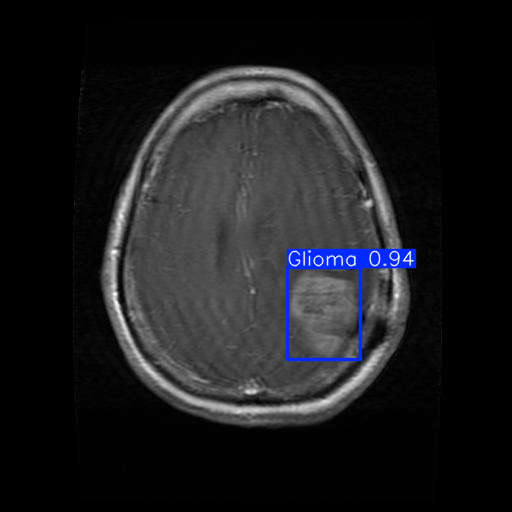

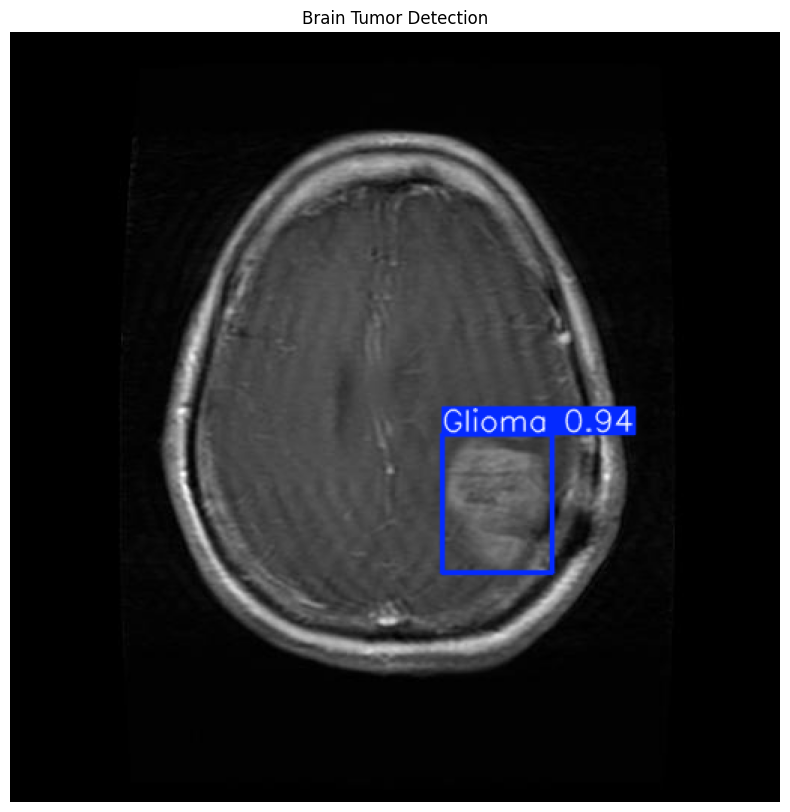

In [ ]:
#detection

from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

# Load your trained model
model = YOLO("/content/best.pt")  # or wherever your model is saved

# Path to the image you want to test
image_path = "/content/mri-brain-tumor/valid/images/Tr-gl_0495.jpg"

# Run detection
results = model(image_path)

# Show results with bounding boxes
results[0].show()  # opens in a new window if local

# To display inside notebook
img = results[0].plot()  # returns numpy array with boxes drawn
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Brain Tumor Detection")
plt.show()


Loaded model from /content/drive/MyDrive/yolo_model/best.pt

0: 640x640 1 Glioma, 105.5ms
Speed: 3.5ms preprocess, 105.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


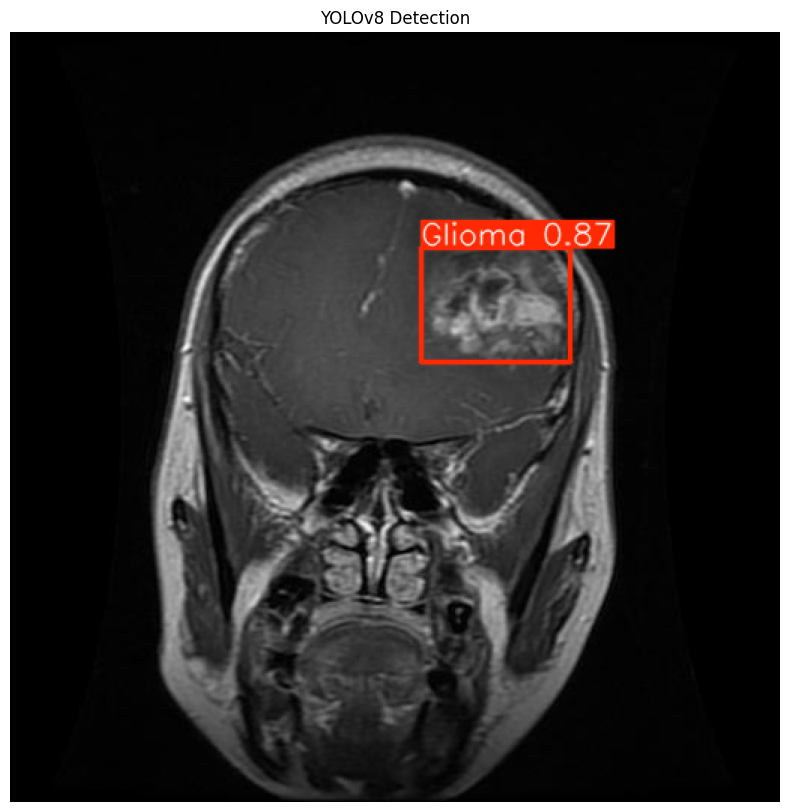

Annotated image saved to /content/drive/MyDrive/yolo_model/outputs/Tr-gl_0505.jpg


In [ ]:
# === Single‐Image Detection with YOLOv8 (from Google Drive) ===
#!pip install ultralytics

# 1) Mount Google Drive


# 2) Imports
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os

# 3) Paths — adjust these to your setup
MODEL_PATH = '/content/drive/MyDrive/yolo_model/best.pt'      # your trained model
IMAGE_PATH = '/content/drive/MyDrive/images_to_detect/Tr-gl_0505.jpg' # the image you want to run

# 4) Load the model
model = YOLO(MODEL_PATH)
print(f"Loaded model from {MODEL_PATH}")

# 5) Read the image
img = cv2.imread(IMAGE_PATH)
if img is None:
    raise FileNotFoundError(f"Image not found: {IMAGE_PATH}")
# Convert BGR → RGB for display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 6) Perform detection
results = model(img_rgb, conf=0.25, iou=0.45)[0]  # returns a Result object

# 7) Plot in‐notebook
annotated = results.plot()  # returns an RGB numpy array with boxes & labels
plt.figure(figsize=(10,10))
plt.imshow(annotated)
plt.axis('off')
plt.title('YOLOv8 Detection')
plt.show()

# 8) Save annotated image (optional)
out_dir = '/content/drive/MyDrive/yolo_model/outputs'
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, os.path.basename(IMAGE_PATH))
cv2.imwrite(out_path, cv2.cvtColor(annotated, cv2.COLOR_RGB2BGR))
print(f"Annotated image saved to {out_path}")


In [ ]:
#mount code to drive
import shutil
# Define the destination path in your Google Drive
save_path = '/content/drive/MyDrive/yolo_model'

# Create the directory if it doesn't exist
import os
os.makedirs(save_path, exist_ok=True)

# Define source paths (these should point to the directories in your Colab environment)
model_weights = '/content/runs/detect/yolov8_brain_tumor/weights/best.pt'
results_file = '/content/runs/detect/yolov8_brain_tumor/results.csv'

# Destination paths in your Google Drive folder
weights_dst = os.path.join(save_path, 'best.pt')
results_dst = os.path.join(save_path, 'results.csv')


# Copy files to Google Drive
if os.path.exists(model_weights):
    shutil.copy(model_weights, weights_dst)
    print(" Copied best.pt to Drive.")
else:
    print(" best.pt not found.")

if os.path.exists(results_file):
    shutil.copy(results_file, results_dst)
    print(" Copied results.csv to Drive.")
else:
    print(" results.csv not found.")



✅ Copied best.pt to Drive.
✅ Copied results.csv to Drive.
